<a href="https://colab.research.google.com/github/hiris25/TEVC-analysis-scripts/blob/master/TEVC_ManualRampAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TEVC - Selectivity**

## Set up libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from scipy import stats
import glob as glob
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'retina'

## Import and prepare data

### Import Files

Import all files from specified folder and combine into one dataframe called 'df'

In [ ]:
all_data = pd.DataFrame()
for f in glob.glob(r'/folderlocation/*.xlsx'):
    df = pd.read_excel(f)
    all_data = all_data.append(df,ignore_index=True)
    
df = all_data

In [ ]:
#plot and view the raw data for each oocyte
sns.set(style="ticks", color_codes=True)

g = sns.FacetGrid(df, col="Oocyte", hue="Buffer", col_wrap=3, height=3, legend_out=True)
g = (g.map(plt.plot, "Voltage", "Current", marker="."))

g.map(plt.axhline, y=0, ls=":", c=".5")
g.map(plt.axvline, x=0, ls=":", c=".5")

g.add_legend()

### Remove excess coloumns and clean data
Here we are keeping only the relevant information, you can add or remove coloumns as you like.
We will also be standardising the units and generally cleaning up the data

In [ ]:
data =  df[['Time'] + ['Inj. ID 1'] + ['Oocyte'] + ['Buffer'] + ['Comp. 1'] + ['conc. 1'] + ['unit 1'] + ['Current'] + ['Voltage'] + ['Start Date'] + ['IV Prot.']]
data = data.rename(columns={'conc. 1': 'Concentration'})

In [ ]:
data = data[['Time'] + ['Inj. ID 1'] + ['Oocyte'] + ['Buffer'] + ['Comp. 1'] + ['Current'] + ['Voltage'] + ['Concentration'] + ['Start Date']]
data.reset_index(drop=True)
data = data.rename(columns={'Comp. 1': 'Agonist'})  
data = data.rename(columns={'Current': 'Response'})    

## Calculate I/Imax for each oocyte

In [ ]:
maxvalues = data.groupby(['Oocyte']).min()["Response"]

normdata = pd.merge(data, maxvalues,  how='left', left_on=['Oocyte'], right_on = ['Oocyte'])

data['Norm_Response'] = - normdata['Response_x'] / normdata['Response_y']

In [ ]:
data = data.drop(columns=['Response'])
data = data.rename(columns={'Norm_Response': 'Response'})  

## Remove time before and after ramp protocol 650 - 8400 ms

In [ ]:
data = data.loc[(data['Time'] >= 650)]
data = data.loc[(data['Time'] <= 8400)]
data.shape

## Calculate agonist subtracted responses for each oocyte and each buffer

comment out if you do **NOT** want to normalise your data

what we want to do here is minus the 0 agonist from the dose for each voltage and each oocyte and each buffer

1. create two df with and without agonist
2. combine these df
3. transform data into new coloum

In [ ]:
data_leak = data.loc[(data.Concentration == '0') | (data.Agonist == 'empty')]

data_leak.shape

(116070, 9)

In [ ]:
data_agonist = data.loc[(data.Concentration != '0') & (data.Agonist != 'empty')]

data_agonist.shape

(116070, 9)

In [ ]:
mergedata = pd.merge(data_agonist, data_leak,  how='left', left_on=['Oocyte','Buffer', 'Time'], right_on = ['Oocyte','Buffer', 'Time'])

mergedata.head(2)

#here we may need to add something to delete rows where agonist response is smaller than buffer - causing problems later

In [ ]:
normdata = mergedata
normdata['Response'] = mergedata['Response_x'] - mergedata['Response_y']

normdata = normdata.rename(columns={'Agonist_x': 'Agonist', 'Concentration_x' : 'Concentration', 'Voltage_x' : 'Voltage', 'Inj. ID 1_x' : 'Injection_ID', 'Start Date_x' : 'Date'}) 
normdata = normdata.drop(columns=['Inj. ID 1_y', 'Response_y', 'Response_x', 'Start Date_y'])
normdata = normdata.drop(columns=['Agonist_y', 'Concentration_y', 'Voltage_y'])

#Plot individual oocyte IVs & exclude outliers and bad data

Here we are plotting individual oocyte IVs so that we can visually check the data and determine if any oocytes need to be ommited

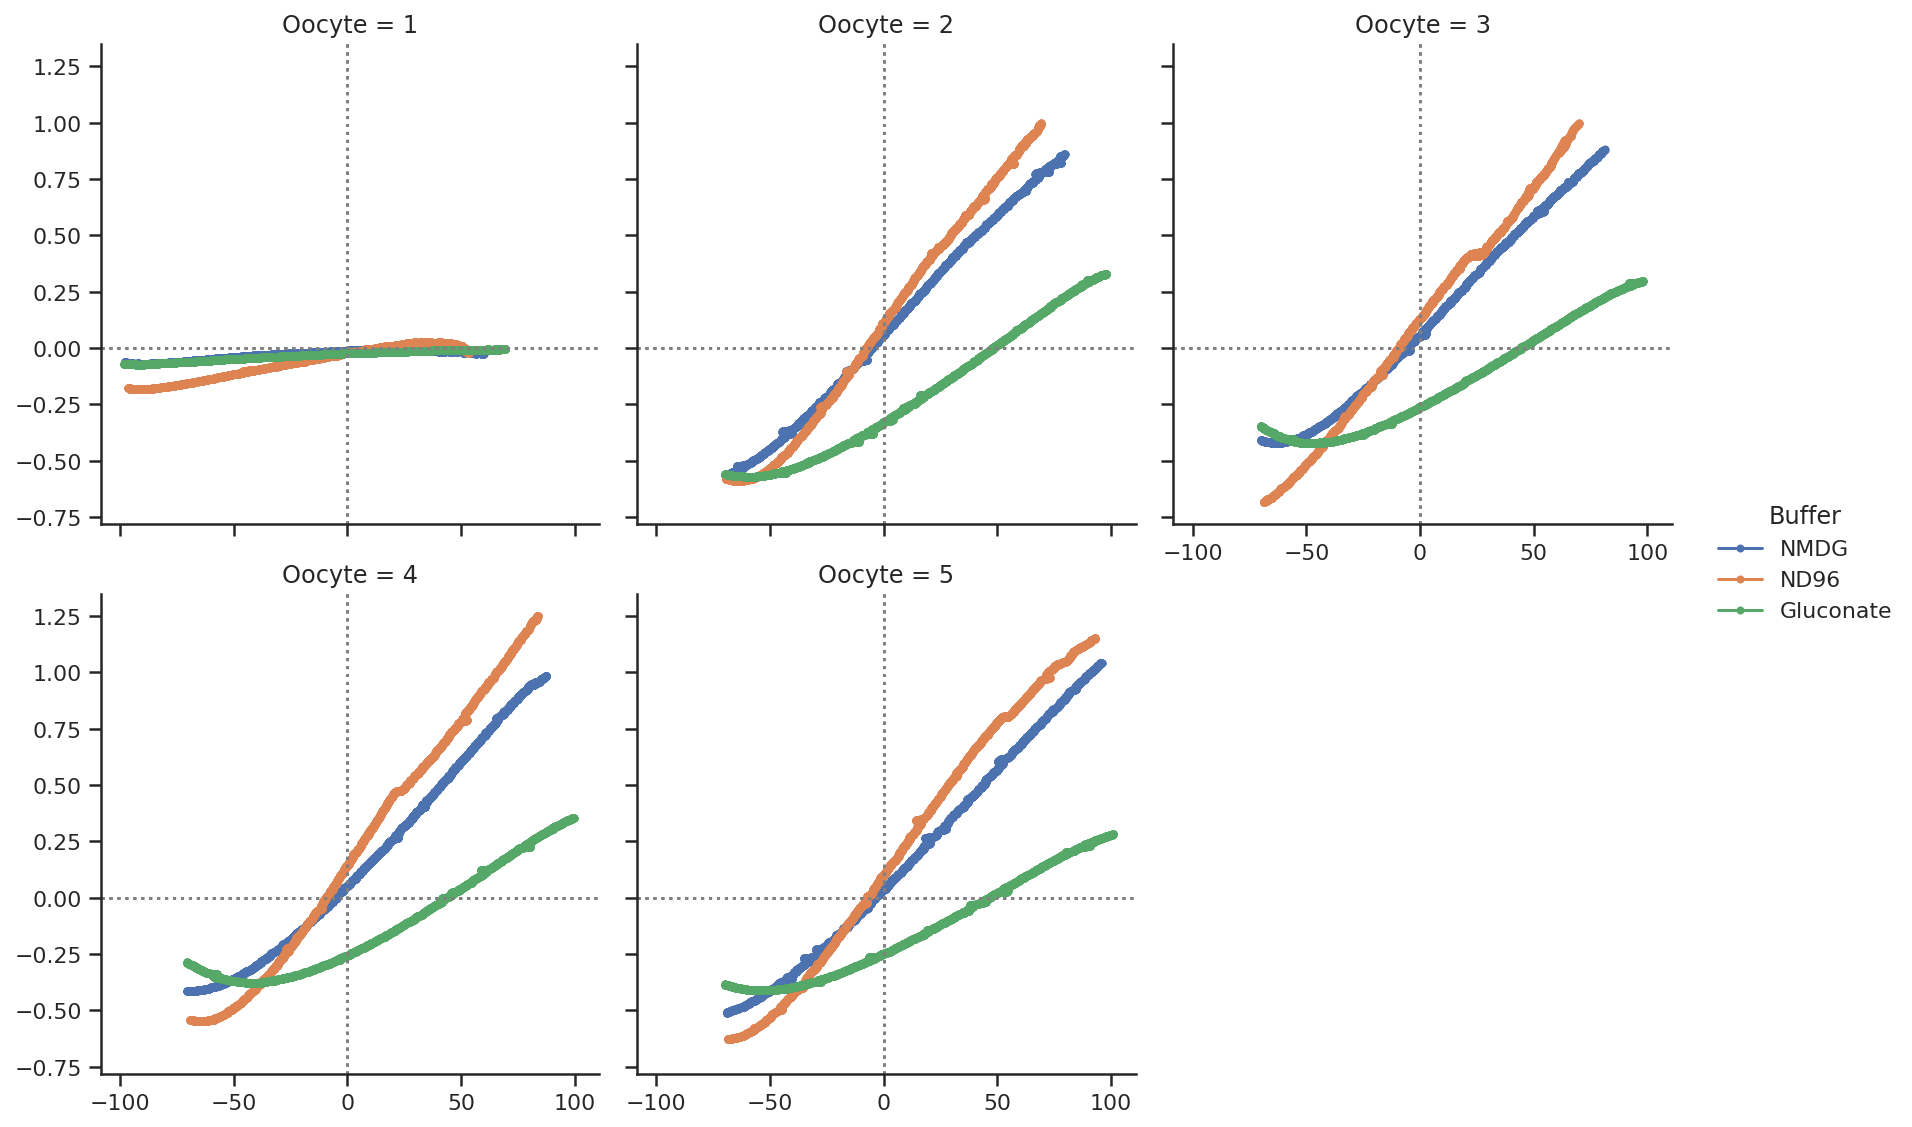

In [ ]:
plot = normdata
sns.set(style="ticks", color_codes=True)

g = sns.FacetGrid(plot, col="Oocyte", hue="Buffer", col_wrap=3, height=4)
g = (g.map(plt.plot, "Voltage", "Response", marker=".")
    .add_legend())

g.map(plt.axhline, y=0, ls=":", c=".5")
g.map(plt.axvline, x=0, ls=":", c=".5")

## Exclude outliers and whole oocytes

### Exclude specific oocytes (optional)
Use the code below to exclude data for indivdiual oocytes (rows)

In [ ]:
#data = data[~data['Oocyte'].isin(['1'])]
#data = data[~data['Well'].isin(['B2'])]
#data = data[~data['Well'].isin(['C2'])]
data.shape

#Line fit & clalculate reversal shifts

## Line fit and plot

In [ ]:
data = data.set_index('Oocyte')

split the dataframe by buffer

In [ ]:
data_ND96 = data.loc[data['Buffer'] == 'ND96']
data_NMDG = data.loc[data['Buffer'] == 'NMDG']
data_Gluc = data.loc[data['Buffer'] == 'Gluconate']

In [ ]:
data_ND96['fit'] = data_ND96.groupby('Oocyte').apply(lambda x: np.polyfit(x.Voltage, x.Response, 2))
data_NMDG['fit'] = data_NMDG.groupby('Oocyte').apply(lambda x: np.polyfit(x.Voltage, x.Response, 2))
data_Gluc['fit'] = data_Gluc.groupby('Oocyte').apply(lambda x: np.polyfit(x.Voltage, x.Response, 2))

## Calculate Erev

In [ ]:
data_ND96[['a', 'b', 'c']] = data_ND96.fit.apply(pd.Series)
data_ND96['d'] = (data_ND96.b**2) - (4*data_ND96.a*data_ND96.c)
#data_ND96['sol1'] = (-data_ND96['b'] - np.sqrt((data_ND96['d'])))/(2*data_ND96['a'])
data_ND96['Erev_ND96'] = (-data_ND96['b'] + np.sqrt((data_ND96['d'])))/(2*data_ND96['a'])

data_NMDG[['a', 'b', 'c']] = data_NMDG.fit.apply(pd.Series)
data_NMDG['d'] = (data_NMDG.b**2) - (4*data_NMDG.a*data_NMDG.c)
#data_ND96['sol1'] = (-data_ND96['b'] - np.sqrt((data_NMDG['d'])))/(2*data_NMDG['a'])
data_NMDG['Erev_NMDG'] = (-data_NMDG['b'] + np.sqrt((data_NMDG['d'])))/(2*data_NMDG['a'])

data_Gluc[['a', 'b', 'c']] = data_Gluc.fit.apply(pd.Series)
data_Gluc['d'] = (data_Gluc.b**2) - (4*data_Gluc.a*data_Gluc.c)
#data_ND96['sol1'] = (-data_ND96['b'] - np.sqrt((data_NMDG['d'])))/(2*data_NMDG['a'])
data_Gluc['Erev_Gluc'] = (-data_Gluc['b'] + np.sqrt((data_Gluc['d'])))/(2*data_Gluc['a'])

In [ ]:
Erev_ND96 = data_ND96.groupby('Oocyte').mean()
Erev_NMDG = data_NMDG.groupby('Oocyte').mean()
Erev_Gluc = data_Gluc.groupby('Oocyte').mean()   

In [ ]:
Erev_ND96 = Erev_ND96.reset_index()
Erev_NMDG = Erev_NMDG.reset_index()
Erev_Gluc = Erev_Gluc.reset_index()

Erev = pd.merge(Erev_ND96,Erev_NMDG,on="Oocyte")
Erev = pd.merge(Erev,Erev_Gluc,on="Oocyte")

Erev = Erev.filter(regex='Erev_', axis=1)

Erev['Oocyte'] = Erev_ND96['Oocyte']

## Calculate Erev shift

In [ ]:
Erev['NMDG_shift'] = Erev['Erev_NMDG'] - Erev['Erev_ND96']
Erev['Gluc_shift'] = Erev['Erev_Gluc'] - Erev['Erev_ND96']

Erev = Erev.set_index('Oocyte')

In [ ]:
Erev.describe()

# Export as .csv
comment out if you do not want to export .csv
change path and file name before running

exports Erevs into a new .csv file

In [ ]:
export = Erev

#export.head()

plot.to_csv(r'filelocation/filename.csv')

# Plot example trace for publication
Here you can plot the trace for you 'favourite' most representative oocyte as well as change perferences for axes colours etc.

In [ ]:
#select your oocyte to plot
plot = data.loc[2]

plot['Voltage_MA'] = plot['Voltage'].rolling(window=5).mean()
plot['Response_MA'] = plot['Response'].rolling(window=5).mean()

#plot = plot.filter(["Voltage_MA", "Response_MA", 'Buffer', 'Time']) 
plot = plot.dropna()

plot = plot.drop_duplicates(subset='Voltage', keep="first")

In [ ]:
#plot the graph
g = sns.lineplot(x="Voltage", y="Response",
                hue="Buffer", dashes=False, data=plot, legend='full')

#Give the axes labels
g.set(xlabel = "Voltage (mV)", ylabel = "I/Imax")

#Move the axes to intersect at 0,0
g.spines['left'].set_position('zero')
g.spines['bottom'].set_position('zero')

#Set the axes limits and title
g.set_title('TITLE', y =1.05) 
g.set_ylim([-0.7, 0.4])
g.set_xlim([-80, 50])

#Move the axes labels
g.xaxis.labelpad = 150
g.yaxis.labelpad = 200

#Set major and minor axes ticks
g.xaxis.set_major_locator(ticker.MultipleLocator(20))
g.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
g.xaxis.set_minor_locator(ticker.MultipleLocator(5))

g.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
g.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
g.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

#Set legened position and title
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()

#right click to download image